# 3.2 Overlap in Lexical and Literary Vocabulary: Digging Deeper

In order to research the relationship between lexical and literary vocabularies in more detail we will look at individual literary texts. Which compositions have more and which have less overlap with the lexical vocabulary?

Longer texts will have more vocabulary items (and Multiple Word Expressions) in common with the lexical corpus than shorter texts, but that does not mean much. For that reason we will look at measures of *lexical richness* and ask: are compositions that use a richer lexicon more likely to utilize lemmas found in the lexical corpus than composition with a lower lexical richness rank? 

### 3.2.0 Preparation

This notebook uses some files that were downloaded or produced in [3_1_Lit_Lex_Vocab.ipynb](./3_1_Lit_Lex_Vocab.ipynb). Run that notebook first, before this one. 

First import the necessary libraries. If you are running this notebook in Jupyter Lab you will need to install the Jupyter Lab ipywidgets extension (see [Introduction](../1_Preliminaries/1_Introduction.md), section 1.2.2.1). 

> The new version of Lexical Richness addresses the problem discussed below - but this version is not (yet) issued on PyPi. Thus %pip install lexicalrichness will get you the wrong version. This can be circumvented by using lexicalrichness_v which is available in utils, as follows:

> import os

> import sys

> util_dir = os.path.abspath('../utils')

> sys.path.append(util_dir)

> from lexicalrichness_v import LexicalRichness as lr

> If lr is used that way, do not use tokenizer = None, preprocessor = None in lit_stats() below.
> Once the PyPi issue is resolved all this text can be removed, lexicalrichness can be imported in the normal way etc. Note that lit_stats then needs tokenizer = None, preprocessor = None

> The notebook will need instructions for how to install lr with pip.

> The [Lexicalrichness](https://pypi.org/project/lexicalrichness/) package by Lucas Shen has been slightly adapted for the present purposes. The package expects a data set in the English language in a raw text format that must be pre-processed (removal of interpunction, digits, etc.) and tokenized (cut up into individual words). These steps do not work well for the present data set. The adapted version, named `lexicalrichness_v` is imported from the `utils` directory. The usage information in the [Lexicalrichness](https://pypi.org/project/lexicalrichness/) website is valid for `lexicalrichness_v` with the following exceptions:
> - the option use_TextBlob in LexicalRichness() is removed
> - the option use_tokenizer in LexicalRichness is added; default is use_tokenizer = False.

> If `use_tokenizer = False` (default) the main function expects a list as input; no tokenizing or preprocessing is performed. If `use_tokenizer = True` the function expects a string, which is preprocessed and tokenized (default behaviour in the original package).

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # this suppresses a warning about pandas from tqdm
import pandas as pd
from ipywidgets import interact
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import zipfile
import json
from tqdm.auto import tqdm
tqdm.pandas() # initiate pandas support in tqdm, allowing progress_apply() and progress_map()
import os
import sys
util_dir = os.path.abspath('../utils')
sys.path.append(util_dir)
from lexicalrichness_v import LexicalRichness as lr

Open the file `litlines.p` which was produced in [3_1_Lit_Lex_Vocab.ipynb](./3_1_Lit_Lex_Vocab.ipynb). The file contains the pickled version of the DataFrame `lit_lines` in which the literary ([epsd2/literary](http://oracc.org/epsd2/literary)) corpus is represented in line-by-line format.

In [2]:
lit_lines = pd.read_pickle('output/litlines.p')

#### 3.2.0.1 Literary: By Composition
The line-by-line representation that was prepared in the previous notebook will be transformed into a composition-by-composition representation. The DataFrame `lit_lines` includes the column `lemma_mwe` in which each line is represented as a sequence of lemmas and/or Multiple Word Expressions (lemmas connected by underscores). The `pandas` `groupby()` function is used here to group on `id_text` and `text_name`. The aggregate function for the `lemma_mwe` column in this case is simply `' '.join`: all the entries (representing lines) are concatenated to form one long sequence of lemmas in a single string representing one composition.

The field `id_text` in the resulting DataFrame has the form 'epsd2/literary/P254863'. In fact, we only need the last 7 characters of that string (the P, Q, or X number of the text), because all texts derive from the same project. We can simplify the `id_text` string with a list comprhension.

In [3]:
lit_comp = lit_lines.groupby(
    [lit_lines["id_text"]]).aggregate(
    {"lemma_mwe": ' '.join}).reset_index()
lit_comp['id_text'] = [id[-7:] for id in lit_comp["id_text"]]
lit_comp[25:35]

,id_text,lemma_mwe
25,P254863,iri[city]n silim[healthy]v/i tag[touch]v/t lul...
26,P254864,kugzu[wise]aj namkugzu[wisdom]n na-an-ak-x[na]...
27,P254865,lu[person]n_niŋgina[truth]n zi[life]n utud[bea...
28,P254866,niŋ[thing]n_gu[neck]n_ŋar[place]v/t niŋ[thing]...
29,P254867,dubsar[scribe]n mu[name]n ni₂-x[na]na igi[eye]...
30,P254868,x-x[na]na mu[name]n diš[one]nu zu[know]v/t x-n...
31,P254869,dubsar[scribe]n emegir[sumerian]n nu-un-zu-x[n...
32,P254870,dubsar[scribe]n_tur[small]v/i bar[outside]n ni...
33,P254871,šah[pig]n šu[hand]n kar[flee]v/i iginzu[as-if]...
34,P254872,amaʾatud[slave]n sulum[contempt]n in-na-x[na]n...


The result is a DataFrame with two columns: `id_text`, and `lemma_mwe`. Each row represents a literary composition from the [epsd2/literary](http://oracc.org/epsd2/literary) corpus. Each cell in the column `lemma_mwe` contains a sequence of lemmas of one composition (with MWEs connected by underscores).

#### 3.2.0.2 Lexical Richness Statistics for the Literary Corpus

In the following we will compute the number of vocabulary matches between each text in the literary corpus and the full lexical corpus. In order to interpret the number of matches properly, we will first compute a number of basic text measures, such as text length, type-token ratio, etc. In all the measures discussed below only the words that are properly lemmatized are counted.

| Measurement       |                                             |
|-------------------|---------------------------------------------|
| Text Length       | Number of lemmatized words and MWEs         |
| Lexical Variation | Number of unique lemmas and MWEs            |
| Type Token Ration | Lexical Variation divided by Text Length    |
| MTLD              | (see below)                                 |

Lexical richness measures the variation in vocabulary usage. Texts that use a relatively low number of unique lexemes (repeat the same words all over the place) receive a low lexical richness score. Texts that use the lexicon more ingenuously, using synonyms or circumscriptions to refer to the same concept, receive a higher lexical richness score. Lexical richness is used, among other things, to identify texts written by langauge learners, to measure aphasia, or to assess the difficulty of a text. For Sumerian literature, we may expect that compositions with high levels of repetition, such as certain hymns and narratives, end up with a low lexical richness score, whereas disputation texts or other compositions that actively explore the lexicon may have a higher score.

The most straightforward lexical richness score is the Type Token Ratio (or TTR), which simply divides the number of unique lexemes by the total number of lexemes. This is a fine measurement to compare texts of (approximately) equal length, but does not work well for a corpus with texts of very different length, as is the case here. Short texts have higher TTR values than long texts, because longer texts will by necessity use the same words over and over again and function words such as "the" or "in" (in English) will be repeated many times whatever the lexical ingenuity of the author. A better measurement is called MTLD or Measure of Textual Lexical Diversity ([McCarthy and Jarvis 2010](https://doi.org/10.3758/BRM.42.2.381)). The MTLD value is calculated as the mean number of words in a text that will bring TTR from 1 (at the first word in the text) down to a threshold value (default is 0.720). In practice that means that a text is cut in many small units, each with approximately the same TTR - eliminating the effect of text length. This is a promising approach that may well work for Sumerian and a Python module that includes MTLD is available ([lexicalrichness](https://pypi.org/project/lexicalrichness/)). Its usage here, however, is experimental and preliminary. The threshold value is based on the observation that when going through a text sequentially the TTR in any text will drop drastically as soon as the first repeated word is encountered. At some place in the text the TTR will stabilize and drop only very gradually later on. That place is approximated by the default TTR threshold value of 0.720. It seems likely, however, that a valid threshold value is language dependent and that a language with very few function words, such as the literary register of Sumerian, might need a higher value (function words drag the TTR down). On the other hand, a corpus of texts with very substantial repetition (occasionaly repetition of entire lengthy passages) may well require a lower threshold. 

In [4]:
def lit_stats(lemmas):
    lemmas = lemmas.split()
    lemmas = [lemma for lemma in lemmas if not '[na]na' in lemma] # remove unlemmatized words
    lex = lr(lemmas) #, tokenizer = None, preprocessor = None)
    length = lex.words # number of lemmatized words
    lex_var = lex.terms # number of unique lemmas
    if length > 0:  # prevent division by 0
        ttr = lex.ttr
        mtld = lex.mtld()
    else:
        ttr = 0
        mtld = 0
    return ' '.join(lemmas), length, lex_var, ttr, mtld

In [5]:
lit_comp['lemma_mwe'], lit_comp['length'], lit_comp['lex_var'], lit_comp['ttr'], lit_comp['mtld'] = \
    zip(*lit_comp['lemma_mwe'].progress_map(lit_stats))
lit_comp = lit_comp.loc[lit_comp['length'] > 0] # remove compositions that have no lemmatized content

We can get a first glimpse of the results by inspecting the basic descriptive statistics. For this, we ignore texts shorter than 50 lemmas, because measures like TTR and MTLD become rather meaningless for very short compositions. It appears that MTLD varies from 9.5 all the way up to 487.3, with a mean value of 78.1. That means that there is a text that, on average, needs only 10 words (two or three lines) to push the TTR under 0.720 - meaning a lot of repeated words (or repeated phrases) all over the place.

In [6]:
lit_comp.loc[lit_comp.length > 50].describe()

,length,lex_var,ttr,mtld
count,489.000000,489.000000,489.000000,489.000000
mean,303.580777,136.993865,0.590037,78.149154
std,411.801304,119.041915,0.160825,57.050472
min,51.000000,19.000000,0.164575,9.492063
25%,96.000000,63.000000,0.475610,36.385597
50%,152.000000,95.000000,0.607921,65.185735
75%,295.000000,162.000000,0.700000,105.613333
max,3139.000000,824.000000,0.966102,487.340000


### 3.2.1 Document Term Matrix

The literary corpus is transformed into a Document Term Matrix (or DTM), a table in which each column represents a lemma (or Multiple Word Expression)  and each row represents a Sumerian composition. Each cell contains a number, 1 or 0, indicating whether or not that word appears in a particular composition. This is called a binary DTM; in a regular DTM each cell represents the frequency of a lexeme (column) in a document (row), or the [TF-IDF](https://en.wikipedia.org/wiki/Tf-idf) value of that word in the document.

The function `CountVectorizer()` (from the `Sklearn` package) is a very flexible tool with many possible parameters. The most common use case is a corpus of raw documents (probably in English), each of them consisting of a text string that needs to be pre-processed and tokenized (turned into a list of words or lemmas) before anything else can be done. Default pre-processing includes, for instance, lowercasing the entire text (so that thursday, Thursday, and THURSDAY will all be recognized as the same lemma). Default tokenizers assume that the text is in a modern (western) language, taking spaces, hyphens, and punctuation marks as word dividers. The structure of our data is much simpler than that. Pre-processing is unnecessary, and tokenization should split the string *only* at blank spaces.

This can be achieved by defining custom tokenizer/preprocessor functions, and tell `Countvectorizer()` to use these. The custom tokenizer consists of the standard Python function `split()`; the preprocessor function does nothing at all. 

The parameter `vocabulary` is set to the variable `lex_vocab`, which includes all lemmas and MWEs in the lexical corpus. Without this parameter, `Countvectorizer()` will simply take each unique lemma in the literary corpus and make that into a column of the DTM. The `vocabulary` option allows us to compare the lexical vocabulary (the column names) with the usage of that vocabulary in each literary text (the rows).

First set the variable `lex_vocab` by opening the file `lex_vocab.txt`, which was produced in [3_1_Lit_Lex_Vocab.ipynb](./3_1_Lit_Lex_Vocab.ipynb) and which contains a list of the full lexical vocabulary. Sort the vocabulary so the columns of the DTM will appear in alphabetical order.

In [7]:
with open('output/lex_vocab.txt', 'r', encoding = 'utf8') as r:
    lex_vocab = r.read().splitlines()
lex_vocab.sort()

In [8]:
cv = CountVectorizer(tokenizer=lambda x: x.split(), preprocessor=lambda x: x, vocabulary=lex_vocab, binary=True)
#Alternative way to do the same thing:
#cv = CountVectorizer(token_pattern = r'[^ ]+', vocabulary=lex_vocab, binary=True)
dtm = cv.fit_transform(lit_comp['lemma_mwe'])
lit_df = pd.DataFrame(dtm.toarray(), columns= cv.get_feature_names(), index=lit_comp["id_text"])
lit_df

,a[arm]n,a[arm]n_ak[do]v/t,a[arm]n_apin[plow]n,a[arm]n_bad[open]v/t,a[arm]n_bad[wall]n,a[arm]n_badsi[parapet]n,a[arm]n_be[diminish]v/t,a[arm]n_da[line]n,a[arm]n_dabašin[object]n,a[arm]n_daluš[sling]n,...,šuʾabdu[1]wn,šuʾi[barber]n,šuʾi[barber]n_egir[back]n,šuʾi[barber]n_gin[firm]v/i,šuʾi[barber]n_gina[offering]n,šuʾi[barber]n_gu[neck]n,šuʾi[barber]n_lugal[king]n,šuʾi[barber]n_saŋ[head]n,šuʾu[stone]n,šuʾura[goose]n
id_text,,,,,,,,,,,,,,,,,,,,,
P209784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P251427,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P251713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P251728,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P252215,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q000823,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q000824,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q000825,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The resulting DataFrame lit_df has a row for each *literary* composition and it has a column for every lemma/expression in the *lexical* corpus. The number of columns, therefore, should correspond to the size of the lexical vocabulary in the Venn diagram produced in the previous notebook:

![venn diagram 3](viz/venn_3.png)

As we have seen in the previous notebook, many of these words/expressions do not appear in the [epsd2/literary](http://oracc.org/epsd2/literary) corpus, and thus all cells in those columns are 0. If we remove those columns, we get the vocabulary that is shared between the lexical corpus and the literary corpus (the intersection of the circles in the Venn diagram). The left side of the Venn diagram (the literary vocabulary that does not appear in lexical texts) is not represented in the DTM. This DTM, therefore, should only be used to research the *intersection* between the two (literary and lexical) vocabularies.

> The number of non-zero columns does not *exactly* correspond to the size of the intersection in the Venn diagram. The reason is that a word like **ašrinna\[object\]n**, a word that in the literary corpus only appears in the MWE **kid\[mat\]n_ašrinna\[object\]n**, is counted as a match in the Venn diagram, but only appears in the column **kid\[mat\]n_ašrinna\[object\]n** in the DTM. See [3_1_Lit_Lex_Vocab.ipynb](./3_1_Lit_Lex_Vocab.ipynb) section 3.1.3.1.

In [9]:
lit_df = lit_df.loc[: , lit_df.sum(axis=0) != 0].copy()
vocab = lit_df.columns # `vocab` is a list with all the vocabulary items currently in `lit_df`
lit_df

,a[arm]n,a[arm]n_ak[do]v/t,a[arm]n_bad[open]v/t,a[arm]n_dar[split]v/t,a[arm]n_daŋal[wide]v/i,a[arm]n_durah[goat]n,a[arm]n_e[leave]v/i,a[arm]n_gab[left]n,a[arm]n_gal[big]v/i,a[arm]n_gud[ox]n,...,šutum[storehouse]n,šutur[garment]n,šuziʾana[1]dn,šuš[cover]v/t,šušana[one-third]nu,šuši[sixty]nu,šušin[1]sn,šušru[distressed]v/i,šuʾi[barber]n,šuʾura[goose]n
id_text,,,,,,,,,,,,,,,,,,,,,
P209784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P251427,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P251713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P251728,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P252215,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q000823,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q000824,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q000825,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The variable `vocab` is a list that includes all lemmas and MWEs that are shared by the literary corpus and the lexical corpus. Save this list for use in section 3.3.

In [10]:
with open('output/lit_lex_vocab.txt', 'w', encoding = 'utf8') as w:
    w.write('\n'.join(vocab))

### 3.2.2 Number of Lexical/Literary Matches per Literary Composition. 
Since the DTM was built with the option `binary = True` the sum of each row equals the number of unique words/expressions that the composition shares with the lexical corpus. The code in the cell below may be simplified as:
```python
lit_df["n_matches"] = lit_df.sum(axis=1)
```
which will yield exactly the same result. The extra elements in the code are added for two reasons. First, if we add additional columns to the DataFrame, for instance composition names, the code will fail unless we add the option `numeric_only = True`. Second, if the (simplified) code is run twice, even with the option `numeric_only=True` the column `n_matches` will become part of the summation and the result in the new `n_matches` column will be twice the correct outcome. By explicitly stating that only the columns named after the lemmas in `vocab` should be used such accidents are avoided.

In [11]:
lit_df["n_matches"] = lit_df[vocab].sum(axis=1, numeric_only=True)

#### 3.2.2.1 Adding Metadata and Lexical Richness Statistics
Above, we computed various statistics for each of the literary compositions. The catalog file for [epsd2/literary](http://oracc.org/epsd2/literary) contains further information (such as the composition name). 

In [12]:
# First get the metadata. 
file = "jsonzip/epsd2-literary.zip" # The ZIP file was downloaded in the previous notebook
z = zipfile.ZipFile(file) 
st = z.read("epsd2/literary/catalogue.json").decode("utf-8")
j = json.loads(st)
cat_df = pd.DataFrame(j["members"]).T
#The important information, giving the title of the literary text is sometimes found in 
# `designation` and sometimes in `subgenre`. Merge those two fields.
cat_df.loc[cat_df.designation.str[:13] == "CDLI Literary", "designation"] = cat_df.subgenre
# Exemplars have a P number (`id_text`), composite texts have a Q number (`id_composite`).
# Merge those two in `id_text`.
cat_df["id_text"] = cat_df["id_text"].fillna(cat_df["id_composite"])
# Keep only `id_text` and `designation`.
cat_df = cat_df[["id_text", "designation"]]

Merge the Lexical Richness statistics (`lit_comp`) with the number of lexical matches from the DTM (`lit_df`) by the shared field `id_text`. Merge the resulting DataFrame (`lit_df2`) with the metadata (`cat_df`). The merge method is "inner," which means that only those rows that exist in all three DataFrames will end up in the new DataFrame. Thus, the compositions with 0 lemmatized words, which were eliminated above, will not re-surface in the new DataFrame.

In [13]:
lit_df2 = pd.merge(lit_comp[["id_text", "length", "mtld", "ttr", "lex_var"]], lit_df["n_matches"], on="id_text", how="inner")
lit_df2 = pd.merge(cat_df, lit_df2, on = 'id_text', how = 'inner')
lit_df2

,id_text,designation,length,mtld,ttr,lex_var,n_matches
0,P209784,"Ontario 2, 506",5,5.000000,1.000000,5,5
1,P251427,"CUSAS 38, 09",164,114.244334,0.664634,109,103
2,P251713,"CUSAS 38, 05",268,89.333333,0.555970,149,129
3,P251728,ETCSL 2.05.01.05 Ishbi-Erra E (witness),58,72.378272,0.844828,49,47
4,P252215,ETCSL 4.10.01 Lament of Lisin (witness),51,91.035000,0.843137,43,40
...,...,...,...,...,...,...,...
896,Q000823,Proverbs: from Ur,1399,117.398601,0.380272,532,482
897,Q000824,Proverbs: from Uruk,44,67.760000,0.818182,36,33
898,Q000825,Proverbs: of unknown provenance,539,87.972272,0.556586,300,280
899,Q002338,Public announcement of the loss of a seal,37,127.773333,0.918919,34,25


Sort by the number of lexical matches.

In [14]:
lit_df2 = lit_df2.sort_values(by = "n_matches", na_position="first", ascending=False)
lit_df2.head()

,id_text,designation,length,mtld,ttr,lex_var,n_matches
537,Q000351,Ninurta's exploits: a šir-sud (?) to Ninurta,3139,149.173640,0.262504,824,713
562,Q000380,The lament for Sumer and Ur,2668,57.629651,0.273988,731,616
551,Q000367,Lugalbanda in the mountain cave,1941,79.044336,0.326636,634,578
839,Q000750,The temple hymns,2498,86.438542,0.279023,697,570
521,Q000334,Enki and the world order,1937,89.129452,0.319050,618,558


#### 3.2.2.2 Normalizing
Lugal-e (or [Ninurta's Exploits](http://etcsl.orinst.ox.ac.uk/cgi-bin/etcsl.cgi?text=c.1.6.2&display=Crit&charenc=gcirc#) has the highest number of matches (more than 700) with the Old Babylonian lexical corpus in [DCCLT](http://oracc.org/dcclt). But this is also the longest composition in the corpus. We can normalize by dividing the total number of matches (`n_matches`) by the number of unique lemmas (`lex_var`) in the text (`norm`). Such numbers mean little for very short texts with just a few (lemmatized) words. In the next section we will add the possibility of excluding texts that fall under a certain minimum length.

In [15]:
lit_df2["norm"] = lit_df2["n_matches"] / lit_df2["lex_var"]
lit_df2.sort_values(by = "norm", na_position="first", ascending=False)

,id_text,designation,length,mtld,ttr,lex_var,n_matches,norm
496,P346924,"UET 6, 0887",4,4.000000,1.000000,4,4,1.0
263,P346368,"UET 6, 0315",24,24.000000,1.000000,24,24,1.0
315,P346507,"UET 6, 0469",31,13.108025,0.645161,20,20,1.0
74,P346109,"UET 6, 0024",30,18.552632,0.700000,21,21,1.0
27,P254865,"UET 6, 0257",5,5.000000,1.000000,5,5,1.0
...,...,...,...,...,...,...,...,...
454,P346828,"UET 6, 0791",2,2.000000,1.000000,2,0,0.0
455,P346829,"UET 6, 0792",5,5.000000,0.600000,3,0,0.0
456,P346830,"UET 6, 0793",2,2.000000,0.500000,1,0,0.0
457,P346831,"UET 6, 0794",1,1.000000,1.000000,1,0,0.0


### 3.2.3 Exploring the Results
The following code displays the results in an interactive table that may be sorted (ascending or descending) in different ways for further exploration. By default, texts shorter than 50 lemmatized words are excluded and only the first 10 columns are displayed. One may change these numbers by moving the slides. The column `id_text` provides links to the editions in [epsd2/literary](http://oracc.org/epsd2/literary).

In [16]:
anchor = '<a href="http://oracc.org/epsd2/literary/{}", target="_blank">{}</a>'
lit = lit_df2.copy()
lit['id_text'] = [anchor.format(val,val) for val in lit['id_text']]

In [17]:
@interact(sort_by = lit.columns, rows = (1, len(lit), 1), min_length = (1,500,5))
def sort_df(sort_by = "norm", ascending = False, rows = 10, min_length = 50):
    return lit.loc[lit.length >= min_length].sort_values(by = sort_by, ascending = ascending).reset_index(drop=True)[:rows].style

interactive(children=(Dropdown(description='sort_by', index=7, options=('id_text', 'designation', 'length', 'm…

### 3.2.4 Discussion
We may now come back to our initial question: is there a correlation between lexical richness of a composition and the size of the intersection of the vocabulary of that composition with the lexical vocabulary? In other words: did Old Babylonian scribes and scholars utilize the lexical corpus when they wished to broaden their vocabulary?

We will define lexical richness with our mtld measure, and for the intersection we use the `norm` variable (normalized for text length).

As it turns out, a correlation between these two variables exists, but is weak:

In [18]:
min_length = 50
lit = lit.loc[lit.length > min_length]
lit['norm'].corr(lit['mtld'])

0.19869367937646304

#### 3.2.4.1 Scatter Plot
We can further explore this correlation by inspecting a scatter plot of mtld and norm.

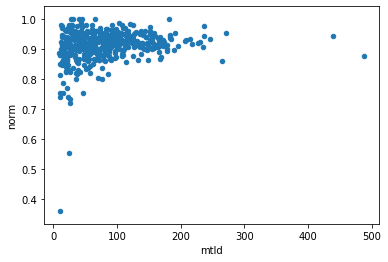

In [19]:
lit.plot.scatter(x = 'mtld', y = 'norm');

The scatter plot shows that, indeed, the text with (by far) the lowest `norm` value ([The Sumerian King List](http://etcsl.orinst.ox.ac.uk/cgi-bin/etcsl.cgi?text=c.2.1.1&display=Crit&charenc=gcirc#)), also receives one of the lowest scores on `mtld` and that texts with the highest `mtld` also score high on `norm`. What the figure also shows is that, with a few exceptions, variation in `norm` is fairly small. The great majority of compositions fall in the 0.85 - 0.95 range.

We can further illustrate that with descriptive statistics of the `norm` variable.

In [20]:
lit['norm'].describe()

count    489.000000
mean       0.911970
std        0.052673
min        0.359833
25%        0.894180
50%        0.919192
75%        0.942387
max        1.000000
Name: norm, dtype: float64

The table shows that the 25%, 50%, and 75% points are all very close to each other, around 0.92. In other words: in the great majority of literary compositions, more than 90% of the lemmas and Multiple Word Expressions are attested in the lexical corpus.

#### 3.2.4.2 Histogram
The histogram of `norm` is another way to visualize the (very) skewed distribution of its values.

Text(0.5, 0, 'norm')

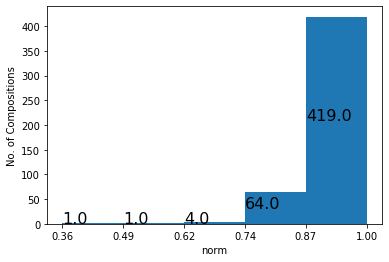

In [21]:
nbins = 5
column = 'norm'
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(lit[column], bins = nbins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f')) # tick labels with two decimals
ax.set_xticks(bins)
for i in range(nbins):
    plt.text(bins[i],counts[i]/2,str(counts[i]), fontsize = 16)
plt.ylabel('No. of Compositions')
plt.xlabel(column)

# For Creating Output Only
The following code is used to create MarkDown tables from Pandas DataFrames. The tables can be included in the Compass Markdown files.

In [22]:
from tabulate import tabulate

In [23]:
lit_tab = lit.copy()
markdown = "[{}](http://oracc.org/epsd2/literary{})"
lit_tab['id_text'] = [markdown.format(val,val) for val in lit_df2.loc[lit_df2.length > min_length, 'id_text']]
lit_tab = lit_tab.round({'ttr' : 3, 'norm': 3, 'mtld' : 3})

In [24]:
rows = 10 # number of rows to be exported
col = 'norm' # column by which to sort
asc = False
tab = tabulate(lit_tab.sort_values(by=col, ascending=asc)[:rows],
         headers= lit_tab.columns , tablefmt="github", showindex=False)
with open('output/lit_tab.txt', 'w', encoding='utf8') as w:
    w.write(tab)

# Testing
Add one word at a time and see how that influences ttr. Does ttr arrive at a plateau?

KeyboardInterrupt: 

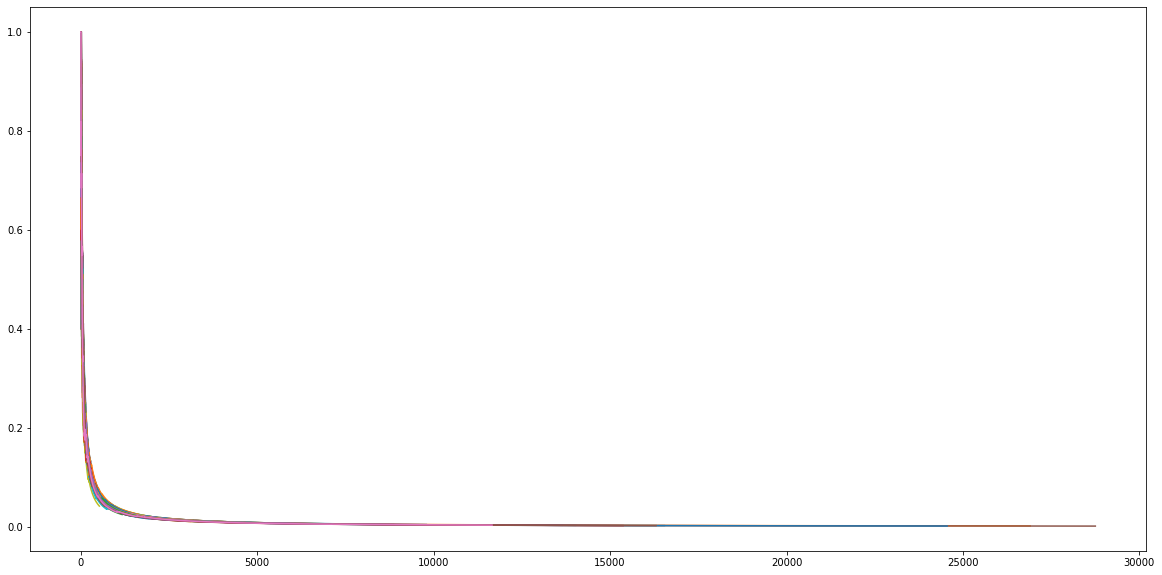

In [25]:
plt.figure(figsize=(20,10))
for id in lit_comp['id_text']:
    c = lit_comp.loc[lit_comp['id_text'] == id, 'lemma_mwe']
    c = c.iloc[0]

    ttr_l = []
    enum = range(1, len(c))
    for ind in enum:
        t = c[:ind]
        ttr = lr(t).ttr
        ttr_l.append(ttr)
    plt.plot(enum, ttr_l)
plt.show()

In [ ]:
lit_df2.loc[(86 < lit_df2.mtld) & (lit_df2.mtld < 162.6)].sort_values(by = 'mtld')

Following needs to be redone with Q numbers

In [ ]:
tetrad = {'c.2.5.8.1' : 1, 'c.2.5.3.2' : 1, 'c.2.5.5.2' : 1, 'c.4.16.1': 1}
decad = {'c.2.4.2.01' : 2, 'c.2.5.5.1' : 2, 'c.5.5.4' : 2, 'c.4.07.2' : 2, 'c.4.05.1' : 2,
         'c.4.80.2' : 2, 'c.1.1.4' : 2, 'c.1.3.2' : 2, 'c.4.28.1' : 2, 'c.1.8.1.5' : 2}
houseF = {'c.5.1.2' : 3,'c.5.1.3' : 3, 'c.1.8.1.4' : 3, 'c.1.6.2' : 3, 'c.2.1.5' : 3,
          'c.2.4.2.02' : 3, 'c.2.2.2' : 3, 'c.5.6.1' : 3, 'c.5.1.1' : 3, 'c.5.3.2' : 3,
          'c.1.4.3' : 3, 'c.5.6.3' : 3, 'c.5.4.1' : 3, 'c.5.3.1' : 3}
proverbs = {'c.6.1.01' : 4, 'c.6.1.02' : 4, 'c.6.1.03' : 4, 'c.6.1.04' : 4, 'c.6.1.05' : 4,
            'c.6.1.06' : 4, 'c.6.1.07' : 4,'c.6.1.08' : 4, 'c.6.1.09' : 4, 'c.6.1.10' : 4,
            'c.6.1.11' : 4, 'c.6.1.12' : 4, 'c.6.1.13' : 4, 'c.6.1.14' : 4,'c.6.1.15' : 4,
            'c.6.1.16' : 4, 'c.6.1.17' : 4, 'c.6.1.18' : 4, 'c.6.1.19' : 4, 'c.6.1.20' : 4,
            'c.6.1.21' : 4, 'c.6.1.22' : 4, 'c.6.1.23' : 4, 'c.6.1.24' : 4, 'c.6.1.25' : 4,
            'c.6.1.26' : 4, 'c.6.1.27' : 4, 'c.6.1.28' : 4, 'c.6.2.1' : 4, 'c.6.2.2' : 4,
            'c.6.2.3' : 4,'c.6.2.4' : 4,'c.6.2.5' : 4}

In [ ]:
educL = {}
educL.update(tetrad)
educL.update(decad)
educL.update(houseF)
educL.update(proverbs)
educ = lit_df2.loc[lit_df2.id_text.isin(educL)].sort_values(by = 'norm')
educ

In [ ]:
educ['category'] = [educL[id] for id in educ.id_text]

In [ ]:
educ.sort_values(by = 'mtld')

In [ ]:
etcsl.norm.describe()

In [ ]:
etcsl.loc[round(etcsl.norm, 3) == 0.874].style

In [ ]:
import seaborn as sns
#colors = {1 :'red', 2:'blue', 3:'green', 4:'black'}
#plt.scatter(educ.norm, educ.mtld, s =75, c=educ['category'].apply(lambda x: colors[x]), alpha = 1)
sns.scatterplot('norm', 'mtld', data=educ, hue='category', size = 'length', sizes = (50, 200), alpha = 0.75)

In [ ]:
lit_df2["mtld"].corr(lit_df2['norm'])

In [ ]:
lit_df2.loc[lit_df2.norm > .5].plot.scatter(x = 'mtld', y = 'norm')

In [ ]:
educL['c.2.5.5.2']

In [ ]:
test_df = lit_df2.loc[lit_df2.norm > .6].copy()
test_df['norm'].corr(test_df['mtld'])

In [ ]:
lit_df2.loc[lit_df2.mtld > 200]

In [ ]:
hymns = etcsl_df2.loc[etcsl_df2.id_text.str.startswith('c.2')]

In [ ]:
hymns.sort_values(by = 'id_text')

In [ ]:
genres = etcsl_df2.groupby(etcsl_df2.id_text.str[:5]).aggregate({'norm' : 'mean'})

In [ ]:
genres.plot()

In [ ]:
etcsl[['mtld', 'length', 'norm', 'lex_var', 'ttr', 'n_matches']].describe()

In [ ]:
DD = set(etcsl_comp.lemma_mwe.iloc[13])

In [ ]:
len(DD - set(lex_vocab))

In [ ]:
len(DD)

In [ ]:
etcsl_comp.iloc[13]

In [ ]:
etcsl_df2.loc[etcsl_df2.id_text == 'c.1.4.3']

In [ ]:
etcsl.norm.median()

> # Some thoughts

> * Step 1. Measure length of lemma_mwe in etcsl_comp and remove rows with len < 200.
> * Step 2. Create DTM (see below) of etcsl_comp, binary = True and vocabulary = lemma_mwe from lex (use lex_lines)
> * Step 3. Order compositions by highest match
> * Step 4. Normalize for text length (from Step 1)
> * Step 5. Same process for individual lex texts (which has highest match for Ura 4?)
> * Step 6. TF-IDF

> In future iteration: do *not* select among lexical texts - let the script figure out which lex compositions are most relevant.

> Perhaps: make DTM first - show that DTM.shape gives same numbers for lex vocabulary as second Venn diagram above. Remove all columns where sum == 0. Show that DTM.shape now gives total of overlap as in Venn diagram above. Then remove rows <= minimum. Tricky!